## Data Splitting and pre-processing

In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [266]:
df = pd.read_excel(r"C:\Users\miaox\Desktop\Coding\DATA1030-Fall2024\Independant Project\sheffield_wildfire_and_climate .xlsx")

In [267]:
print(df.shape)

(537, 8)


In [268]:
print (df.columns)

Index(['year', 'month', 'tmax_degC', 'tmin_degC', 'airfrost_days',
       'totalrain_mm', 'totalsun_hours', 'wildfire_quantity'],
      dtype='object')


In [269]:
#copy df_original into new df_features
df_features = df.copy()

In [270]:
#feature 'year_squared'
df_features['year_squared'] = df['year'] ** 2

In [271]:
#feature 'year_month'
df_features['year_month'] = df_features['year'].astype(str) + '_' + df_features['month'].astype(str).str.zfill(2)

#feature 'totalrain_mm_avg4'
#feature 'tmax_degC_avg4'
df_features['totalrain_mm_avg4'] = df_features['totalrain_mm'].rolling(window=4, min_periods=1).mean()
df_features['tmax_degC_avg4'] = df_features['tmax_degC'].rolling(window=4, min_periods=1).mean()

In [272]:
df_features['year_month2'] = df_features['year'].astype(str) + '_' + df_features['month'].astype(str).str.zfill(2)

# Convert 'year_month' to datetime and extract 'year' and 'month' features
df_features['year_month_dt'] = pd.to_datetime(df_features['year_month2'], format='%Y_%m')
df_features['year'] = df_features['year_month_dt'].dt.year
df_features['month'] = df_features['year_month_dt'].dt.month

# Create month_sin and month_cos features
df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)

# Print the column list to verify the presence of 'year_month' and other features
print("Final columns:")
print(df_features.columns.tolist())  

Final columns:
['year', 'month', 'tmax_degC', 'tmin_degC', 'airfrost_days', 'totalrain_mm', 'totalsun_hours', 'wildfire_quantity', 'year_squared', 'year_month', 'totalrain_mm_avg4', 'tmax_degC_avg4', 'year_month2', 'year_month_dt', 'month_sin', 'month_cos']


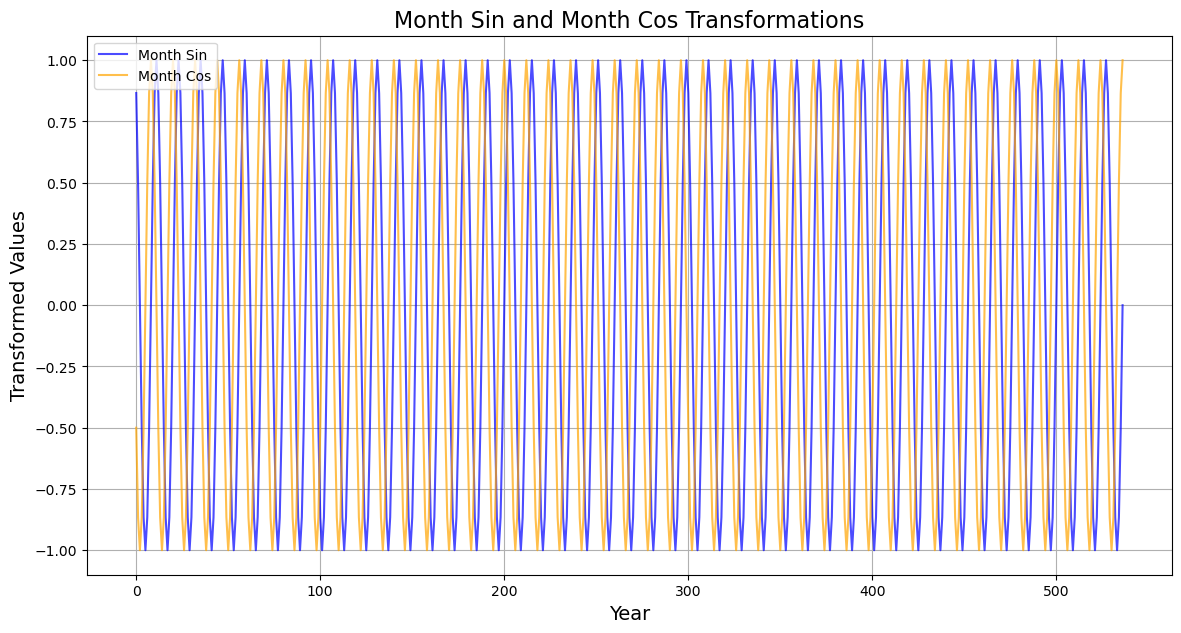

In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Plotting month_sin and month_cos
plt.figure(figsize=(14, 7))

# Plot month_sin
plt.plot(df_features.index, df_features['month_sin'], label='Month Sin', color='blue', alpha=0.7)

# Plot month_cos
plt.plot(df_features.index, df_features['month_cos'], label='Month Cos', color='orange', alpha=0.7)

# Adding labels and title
plt.title('Month Sin and Month Cos Transformations', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Transformed Values', fontsize=14)
plt.legend()
plt.grid()
plt.show()


In [274]:
df_features.rename(columns={'wildfire_quantity': 'wildfire_frequency'}, inplace=True)

In [275]:
print(df_features.columns.tolist())

['year', 'month', 'tmax_degC', 'tmin_degC', 'airfrost_days', 'totalrain_mm', 'totalsun_hours', 'wildfire_frequency', 'year_squared', 'year_month', 'totalrain_mm_avg4', 'tmax_degC_avg4', 'year_month2', 'year_month_dt', 'month_sin', 'month_cos']


In [276]:
#drop features from above list
df_features.drop(columns=['tmin_degC', 'month', 'year_month_dt', 'year_month2'], inplace=True)

In [277]:
print(df_features.columns.tolist())

['year', 'tmax_degC', 'airfrost_days', 'totalrain_mm', 'totalsun_hours', 'wildfire_frequency', 'year_squared', 'year_month', 'totalrain_mm_avg4', 'tmax_degC_avg4', 'month_sin', 'month_cos']


In [284]:
#Data splitting
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

#target
Y = df_features['wildfire_frequency']

#feature variables
X = df_features[['year_month', 'year', 'year_squared', 'month_cos', 'month_sin', 'tmax_degC', 
         'airfrost_days', 'totalrain_mm', 
         'totalsun_hours', 'tmax_degC_avg4', 
         'totalrain_mm_avg4']]

train_size = 0.7
test_val_size = 1 - train_size  # This will be 0.3 (15% each for test and validation)

#First, split into training and a temporary test/validation set
split_index = int(len(df) * train_size)

X_train, X_temp = X.iloc[:split_index], X.iloc[split_index:]
Y_train, Y_temp = Y.iloc[:split_index], Y.iloc[split_index:]

#Now split the temporary test/validation set into test and validation (15% each), suffle=false to ensure chronological order
X_test, X_val, Y_test, Y_val = train_test_split(X_temp, Y_temp, test_size=0.5, shuffle=False)

# Double-check the split sizes
print(f'Training set size: {X_train.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')
print(f'Validation set size: {X_val.shape[0]}')

# Set up TimeSeriesSplit for cross-validation (with specified number of folds)
tscv = TimeSeriesSplit(n_splits=3)  # You can adjust n_splits for the number of folds

# Example of how to use TimeSeriesSplit for cross-validation
for train_index, test_index in tscv.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    Y_train_fold, Y_test_fold = Y_train.iloc[train_index], Y_train.iloc[test_index]
    print(f'Train fold size: {len(X_train_fold)}, Test fold size: {len(X_test_fold)}')

Training set size: 375
Test set size: 81
Validation set size: 81
Train fold size: 96, Test fold size: 93
Train fold size: 189, Test fold size: 93
Train fold size: 282, Test fold size: 93


In [285]:
print(X_train['year_month'])

0      1976_04
1      1976_05
2      1976_06
3      1976_07
4      1976_08
        ...   
370    2007_02
371    2007_03
372    2007_04
373    2007_05
374    2007_06
Name: year_month, Length: 375, dtype: object


In [286]:
print(X_test['year_month'])

375    2007_07
376    2007_08
377    2007_09
378    2007_10
379    2007_11
        ...   
451    2013_11
452    2013_12
453    2014_01
454    2014_02
455    2014_03
Name: year_month, Length: 81, dtype: object


In [287]:
print(X_val['year_month'])

456    2014_04
457    2014_05
458    2014_06
459    2014_07
460    2014_08
        ...   
532    2020_08
533    2020_09
534    2020_10
535    2020_11
536    2020_12
Name: year_month, Length: 81, dtype: object


### Pre-processing 

In [289]:
# List of features to calculate min and max for
features = ['year_month', 'year', 'month_sin', 'month_cos', 'year_squared', 'tmax_degC', 'airfrost_days', 'totalrain_mm', 
            'totalsun_hours', 'tmax_degC_avg4', 'totalrain_mm_avg4']

# Calculate min and max for each feature
min_values = df_features[features].min()
max_values = df_features[features].max()

# Print the results
print("Minimum values for each feature:")
print(min_values)
print("\nMaximum values for each feature:")
print(max_values)


Minimum values for each feature:
year_month           1976_04
year                    1976
month_sin               -1.0
month_cos               -1.0
year_squared         3904576
tmax_degC                1.0
airfrost_days              0
totalrain_mm             4.6
totalsun_hours           5.8
tmax_degC_avg4          4.25
totalrain_mm_avg4       16.2
dtype: object

Maximum values for each feature:
year_month           2020_12
year                    2020
month_sin                1.0
month_cos                1.0
year_squared         4080400
tmax_degC               25.6
airfrost_days             25
totalrain_mm           285.6
totalsun_hours         290.8
tmax_degC_avg4        22.025
totalrain_mm_avg4     137.85
dtype: object


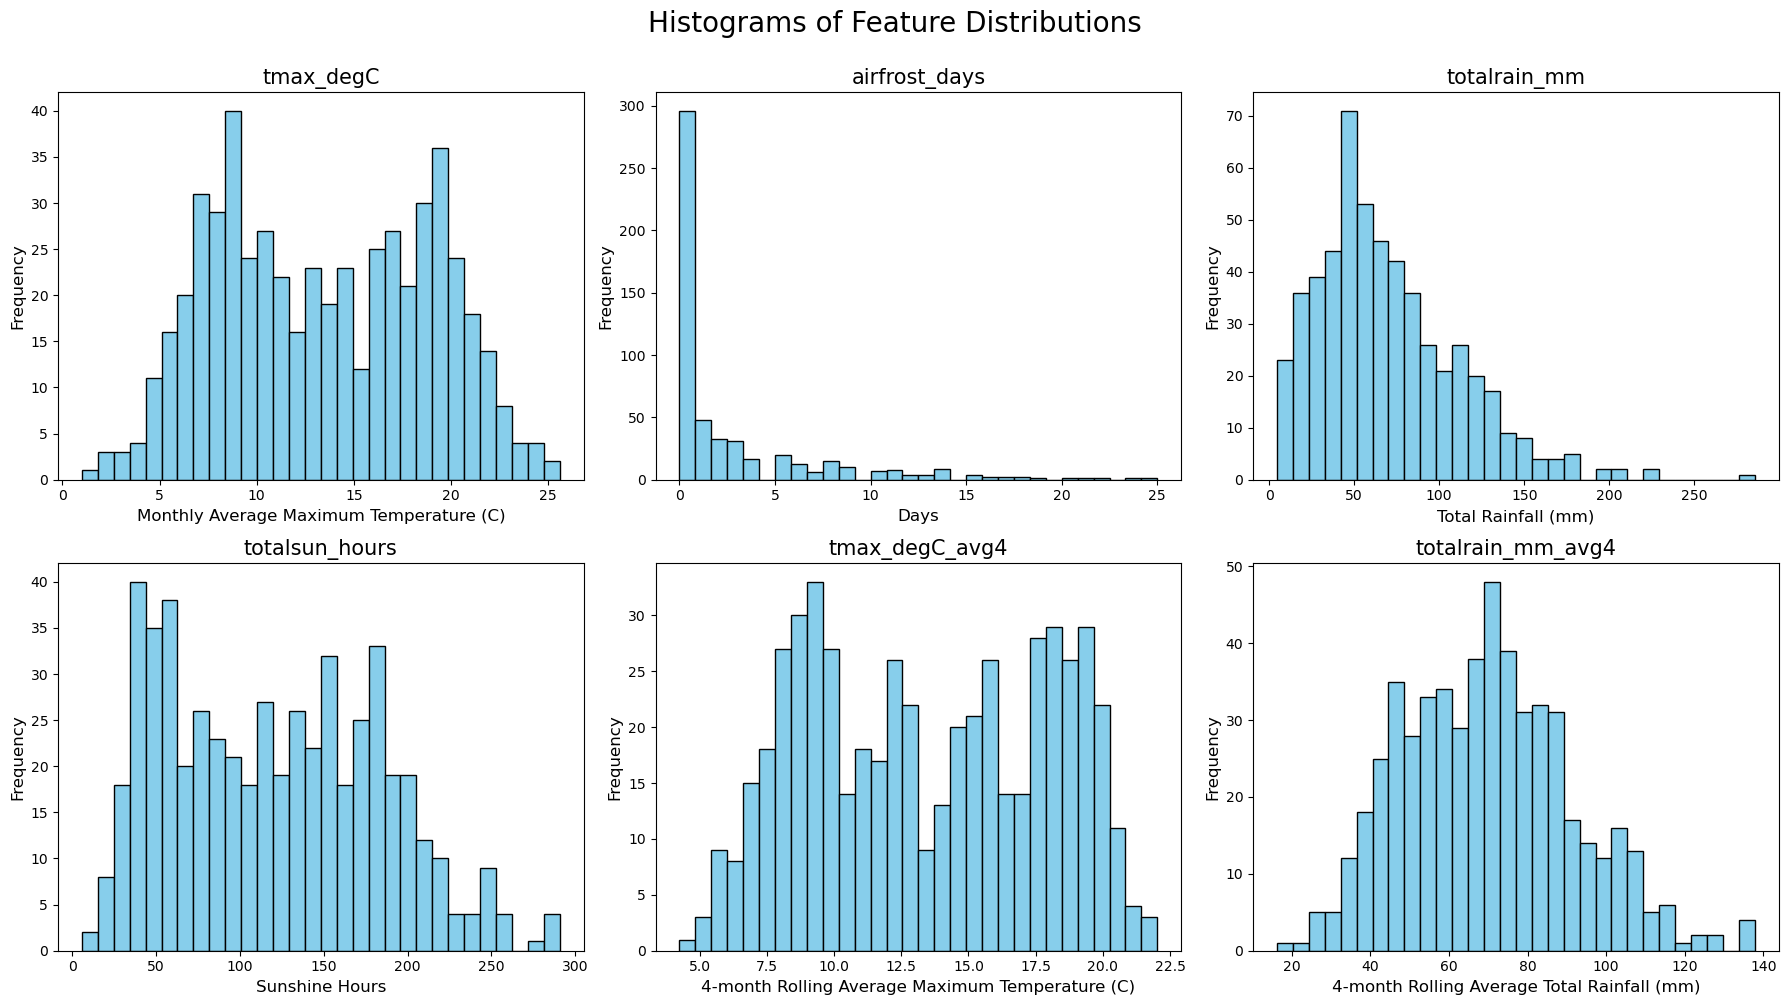

In [234]:
import matplotlib.pyplot as plt

# List of features to plot histograms for
features = ['tmax_degC', 'airfrost_days', 'totalrain_mm', 
            'totalsun_hours', 'tmax_degC_avg4', 
            'totalrain_mm_avg4']

x_labels = ['Monthly Average Maximum Temperature (C)', 'Days', 'Total Rainfall (mm)', 
            'Sunshine Hours', '4-month Rolling Average Maximum Temperature (C)', 
            '4-month Rolling Average Total Rainfall (mm)']


# Set up the figure and axes for the subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.suptitle('Histograms of Feature Distributions', fontsize=20, y=1.0)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each feature and plot a histogram
for i, feature in enumerate(features):
    axes[i].hist(df_features[feature], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(f'{feature}', fontsize=15)
    axes[i].set_xlabel(x_labels[i], fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


In [290]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

mm_ftr = ['airfrost_days']
s_ftrs = ['tmax_degC', 'totalsun_hours', 'tmax_degC_avg4', 'totalrain_mm', 
          'totalrain_mm_avg4', 'month_sin', 'month_cos', 'year_squared']

Sscaler = StandardScaler()
print('Training:', Sscaler.fit_transform(X_train[s_ftrs]))
print('Validation:', Sscaler.transform(X_val[s_ftrs]))
print('Test:', Sscaler.transform(X_test[s_ftrs]))

MMscaler = MinMaxScaler()
print('Training:', MMscaler.fit_transform(X_train[mm_ftr]))
print('Validation:', MMscaler.transform(X_val[mm_ftr]))
print('Test:', MMscaler.transform(X_test[mm_ftr]))

Training: [[-0.29330448 -0.04037354 -0.35501472 ...  1.2212389  -0.69728257
  -1.69872873]
 [ 0.4613067   0.45815994  0.10622842 ...  0.70290235 -1.21425238
  -1.69872873]
 [ 1.6576415   2.01665231  0.74746889 ... -0.00515856 -1.40347646
  -1.69872873]
 ...
 [ 0.4613067   1.34018072 -0.50126255 ...  1.2212389  -0.69728257
   1.7350267 ]
 [ 0.4244964   0.36612299 -0.16376757 ...  0.70290235 -1.21425238
   1.7350267 ]
 [ 0.97665092  0.54866294  0.39872408 ... -0.00515856 -1.40347646
   1.7350267 ]]
Validation: [[ 1.66824286e-01  8.71283135e-03 -6.19385797e-01 -2.30384754e-01
   7.40648855e-01  1.22123890e+00 -6.97282571e-01  2.51778823e+00]
 [ 6.08547904e-01  3.86064330e-01 -1.24393152e-01  1.27513928e+00
   7.35812255e-01  7.02902345e-01 -1.21425238e+00  2.51778823e+00]
 [ 1.12389212e+00  3.56919295e-01  4.88722738e-01 -5.86581292e-01
   6.49179091e-04 -5.15855562e-03 -1.40347646e+00  2.51778823e+00]
 [ 1.82328785e+00  1.80803522e+00  1.14121304e+00 -1.18974076e+00
  -3.45167663e-01 -7.